# Milestone 3 : Final analysis

This notebook is showing how we obtained the plots in our website. We separated from milestone 2 notebook which presents data wrangling and initial analysis in a separate file.

### Table of Contents

* [Section 0](#section0): Imports
* [Section 1](#section1): Loading files and processing
* [Section 2](#section2): Analysis of actions more performed by one gender than the other
* [Section 3](#section3): Categories of actions & useful functions for analysis
* [Section 4](#section4): Gender stereotypes comparison trough epochs
* [Section 5](#section5): Gender stereotypes comparison trough movie genres
* [Section 6](#section6): Gender stereotypes comparison trough world region
* [Section 7](#section7): Gender stereotypes comparison through writer gender
* [Section 8](#section8): Gender stereotypes comparison through producer gender



## 0. Imports <a class="anchor" id="section0"></a>

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import xml.etree
import matplotlib.pyplot as plt
import seaborn as sns
from implementations import *
import csv
import gzip
import xml.etree.ElementTree as ET
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import nltk
import spacy
import numpy.random as random
from matplotlib.ticker import FuncFormatter
import math
import json
import pickle

# nltk.download('averaged_perceptron_tagger')

## 1. Loading files and processing <a class="anchor" id="section1"></a>

In [171]:
# load data
movie_md = load_movie_md()
df = pd.read_csv('characters_actions.csv')

#### Obtaining the final action dataframe :

In [28]:
# we remove all actions for which the first letter is upper (due to some problem,
# some actions has been confound with names)

def upper(word):
    return word[0].isupper()

df = df[~df['action'].apply(upper)]

# lemmatize verbs and uppercase them

lemmatizer = WordNetLemmatizer()
df['action'] = df['action'].apply(lambda x: lemmatizer.lemmatize(x,'v'))

In [174]:
# some irrelevant words we found, due to the mistakes made by stanford corenlp
irrelevant_words = ['\'s', 'and', 'with', 'of', 'to', 'by', 'for', 'in', 'is', 'he', 'has', 'from','as','his', 'on', 'dr.', 'a', 'john', 'drs.', 'father', 'son', 'friend', 'daughter', 'wife', 'mother', 'family', 'sister', 'brother', 'man', 'men', 'captain','singh', 'jack', 'king', 'girl', 'woman', 'girlfriend', 'mary', 'husband', 'parent', 'lady', 'children', 'white', 'car', 'room', 'annie', 'lady', 'queen', 'boy', 'student', 'the', 'friends', 'her', 'home', 'ann', 'anne', 'aunt', 'father', 'girl', 'jane', 'man', 'ms.', 'princess', 'sir', 'sister', 'snow', 'brothers', 'mrs.', 'mrs', 'mr', 'winter', 'apartment', 'mr.', 'widow', 'jim', 'larry', 'van', 'officer','pregnant', 'teacher', 'relationship', 'team', 'socialite', 'maid', 'distraught', 'susan', 'elizabeth', 'anna', 'l', 'sentence', 'steve', 'charlie', '|', 'heartbroken', 'kitty', 'fred', 'boyfriend', 'eddie', 'wealthy', 'delight', 'wound', 'upset', 'alex', 'de', 'crew', 'harry', 'ryan', 'lisa', 'adam', 'place', 'fire', ]

# we make a loop over all these words to find them in our dataframe
conditions = (df['action']!='')
for irr_wrd in list(set(irrelevant_words)):
    conditions = conditions&(df['action']!=irr_wrd)
    
# let's remove those words
act_df_treated = df[conditions]

# now we merge the actions made by characters with data about the movies 
char_description_total = act_df_treated.merge(movie_md, left_on ='movie id', right_on = 'Wikipedia movie ID')

# differents epochs for which we make our analysis and compare results, we will use it after
epochs = [1914, 1945, 1970, 1990, 2000, 2007, 2022]
df_epochs = [char_description_total.query('`Movie release date` >=' + str(epochs[i]+1) + ' and `Movie release date` <= ' + str(epochs[i+1])) for i in range(len(epochs)-1)]

In [178]:
# plot some actions of the dataframe
char_description_total.sample(5)[['actor name', 'actor gender', 'action', 'Movie name', 'Wikipedia movie ID', 'actor id']]

,actor name,actor gender,action,Movie name,Wikipedia movie ID,actor id
839662,Chris Kattan,M,inform,Undercover Brother,1182345,/m/02rwns
245492,Sun Chien,M,hire,Kid with the Golden Arm,10603354,/m/0gc106j
1354922,Revathi,F,ask,Anjali,1437474,/m/0brddh
1327525,Mel Blanc,M,kick,Prince Violent,23646229,/m/0c5vh
966534,Charles Malik Whitfield,M,go,The Temptations,1501461,/m/0k6mn_


## 2. Analyze actions more performed by one gender than the other <a class="anchor" id="section2"></a>

Here is the formula we use to compute frequency for each action, and each gender : 


$$ frequency_{action}^{males} = \frac{number\ of\ occurence_{action}^{males}}{number\ of\ occurence_{all\ actions}^{males}} $$


$$ frequency_{action}^{females} = \frac{number\ of\ occurence_{action}^{females}}{number\ of\ occurence_{all\ actions}^{females}} $$

In [164]:
# Isolate males and females dataframes to make analysis 
male_description = char_description_total[char_description_total['actor gender']=='M']
female_description = char_description_total[char_description_total['actor gender']=='F']

# For each gender, we compute the frequency of use, for each action of the dataframe.
# we make our computation based on frequencies because the number of actions performed
# by males is two times the number of actions made by females.
m = male_description.groupby('action', as_index = False).count()[['action', 'actor name']]
m['actor name'] *= 100/male_description.shape[0]

f = female_description.groupby('action', as_index = False).count()[['action', 'actor name']]
f['actor name'] *= 100/female_description.shape[0]

# then, we can mergeboth dataframes on actions so for each action we have frequencies
# of use for males, and for females
merged_df = m.merge(f, on = 'action', suffixes=('_m', '_f'))

# frequency ratio compare, for each action, frequency for males over frequency for females
merged_df['freq_ratio'] = merged_df['actor name_m']/merged_df['actor name_f']

print('male actions size is    : {}'.format(male_description.shape[0]))
print('female actions size is  : {}'.format(female_description.shape[0]))

male actions size is    : 1176968
female actions size is  : 550287


In [167]:
# plot actions with the smallest frequenty ratio (i.e : the words most said by females rather than males)
merged_df.query(' `actor name_m`>0.05 and `actor name_f`>0.05').sort_values('freq_ratio').head(10)[['action', 'freq_ratio']]

,action,freq_ratio
4038,marry,0.424134
3741,kiss,0.441372
3950,love,0.450952
5883,seduce,0.503511
3953,lover,0.522268
3587,interest,0.537010
534,attract,0.538183
6118,sleep,0.563201
3724,kidnap,0.563817
3101,happen,0.565243


In [168]:
# plot actions with the highest frequenty ratio (i.e : the words most said by males rather than females)
merged_df.query(' `actor name_m`>0.1 and `actor name_f`>0.1').sort_values('freq_ratio', ascending=False).head(10)[['action', 'freq_ratio']]

,action,freq_ratio
4569,order,2.339534
2637,fight,2.101896
5995,shoot,1.923784
454,arrest,1.836877
3728,kill,1.729585
3134,head,1.579661
1146,chase,1.508513
1038,capture,1.488515
4876,plan,1.469638
4003,manage,1.468721


## 3. Categories of actions & useful functions for analysis <a class="anchor" id="section3"></a>

In [128]:
# Here are some list of verbs assiociated with interesting subjects for the comparison male/female in movies
# we found those lists by browsing online for vocabulary list and asking chatGPT, and then we checked them

# list of verbs associated with the subject 'violence'
violence = ['anger', 'arrest', 'assassinate', 'assault', 'attack', 'beat', 'confront',  'defeat', 'defend', 'destroy', 'die', 'eliminate', 'enrage', 'fight', 'harass', 'hurt', 'hunt', 'imprison', 'kick', 'kill', 'knock', 'murder', 'shoot',  'threaten', 'torture', 'gun',"attack","beat","bludgeon","box","buffet","club","damage","devastate","disable","exert","fight","harm","hit","hurt","injure", "manhandle","maul","maim","pommel","pound","punch","ravage","rough","savage", "strike","thrash","thump","wallop","wound","murder","slay","assassinate","eliminate","execute","liquidate","dispatch","massacre","exterminate","butcher", "decimate","extinguish","remove","eradicate","finish","snuff","fight","arrest", "abduct",    "ambush",    "assassinate",    "attack",    "beat",    "berate",  "bully",    "burn",    "choke",    "coerce",    "conquer",    "corrupt",  "decimate",    "defeat",    "destroy",    "devastate",    "disarm",  "disembowel",    "disintegrate",    "dismember",    "electrocute",    "enslave",    "exterminate",    "fear",    "fight",    "flog",    "gag",  "gang up on",    "gouge",    "grind",    "harm",    "hate",    "haunt", "humiliate",    "hunt",    "intimidate",    "invade",    "isolate",    "lynch",    "massacre",    "maul",    "murder",    "mutilate",    "oppress",  "overpower",    "persecute",    "pillage",    "plunder",    "poison",    "pound",    "rape",    "ravage",    "ravish",    "rebel",    "remorse",   "repress",    "resort",    "rob",    "sabotage",    "savage",    "scald", "slaughter",    "smash",    "strangle",    "terrorize",    "torture","trample",    "tyrannize",    "undermine",    "vanquish",    "vandalize","violate",    "wage",    "whip",    "wound"]
violence = list(set(violence))

# list of verbs assciated with the subject 'love/seduction'
love_seduction = ['seduce', 'prostitute', 'miss', 'marry', 'love', 'kiss', 'engage', 'date', 'attract', 'flirt', 'divorce', 'cheat', 'dance', 'sleep', 'separate', 'sleep', 'touch', "adore", "desire",'seduce', 'prostitute', 'miss', 'marry', 'love', 'kiss', 'engage', 'attract', 'flirt', 'divorce', 'cheat', 'dance', 'sleep', 'separate', 'sleep','touch', "lust", "attract", "infatuate", "devote", "admirate", "care",  "concern", "warmth",  "sentiment", "intimacy", "closeness", "connection", "attachment", "bond", "union", "relationship",  "commitment",     "faithfulness", "loyalty", "devote", "care", "concern", "fondness", "warmth",     "sentimentality", "sentiment", "empathy", "intimacy", "closeness", "connection",     "attachment", "bond", "union", "relationship",  "commitment", "faithfulness", "loyalty",     "devotion", "care", "concern",  "fondness", "warmth", "sentimentality", "sentiment",     "empathy", "intimacy",  "closeness", "connection", "attachment", "bond", "union",     "relationship",   "commitment", "faithfulness", "loyalty", "hug", "kiss", "cuddle", "caress",  "embrace", "snuggle", "spoon", "nuzzle", "cuddle", "snuggle", "wed", "marry",   "join", "unite", "pledge", "commit", "enter", "tie", "become", "invite", "marries", "parent", "nurture", "protect", "provide", "support", "guide", "teach", "raise",  "love", "care", "bond", "unite"]
love_seduction =  love_seduction + [ "adore",    "allure",    "attract",    "beguile",    "cherish",    "court",    "crave",    "delight",    "desire",    "entice",    "flirt",    "fondle",    "glorify",    "gratify",    "idolize",    "infatuate",    "lure",    "magnetize",    "mesmerize",    "mesmerise",    "nuzzle",    "pamper",    "passion",    "persuade",    "possess",    "ravish",    "seduce",    "smooch",    "solicit",    "tempt",    "woo",    "yearn",    "amour",    "caress",    "cherish",    "coo",    "cuddle",    "enamor",    "enrapture",    "enthrall",    "entreat",    "flirt",    "fondle",    "hug",    "idolize",    "infatuate",    "kiss",    "long",    "love",    "luxuriate",    "massage",    "moon",    "nuzzle",    "ogle",    "pet",    "please",    "praise",    "relish",    "romance",    "smooch",    "snuggle",    "stroke",    "treasure",    "tryst",    "adore",    "affection",    "amour",    "appreciation",    "attraction",    "devoted",    "devotedness",    "enthusiasm",    "fondness",    "friendship",    "tenderness",    "warmth",    "worshipping",    "adoration",    "admiration",    "amatory",    "amorous",    "ardent",    "attached",    "captivated",    "covetous",    "devoted",    "enamored",    "fascinated",    "fervent",    "fervid",    "enthusiastic",    "passionate",    "smitten",    "tender",    "warm",    "zealous",    "craze",    "delusion",    "infatuation",    "obsession"]
love_seduction = list(set(love_seduction))

# list of verbs assciated with the subject 'success'
success = ['Excel', 'Master', 'Finish', 'Achieve', 'Get', 'Fulfill', 'Surmount', 'Realize', 'Prosper', 'Pass', 'Gain', 'Complete', 'Accomplish', 'Make', 'Win', 'Attain', 'Overcome', 'Advance', 'Triumph', 'Conquer', 'Secure', 'Acquire', 'Perform', 'Establish', 'Obtain', 'Conclude', 'acquit', 'succeed']
success = [act.lower() for act in success]
success = success +  [    "achieve",    "acquire",    "advance",    "attain",    "benefit",    "capture",    "conquer",    "cultivate",    "develop",    "earn",    "excel",    "flourish",    "gain",    "grow",    "improve",    "master",    "maximize",    "obtain",    "overcome",    "prosper",    "reach",    "realize",    "succeed",    "thrive",    "win",    "apply",    "begin",    "capitalize",    "commit",    "concentrate",    "dedicate",    "determine",    "discipline",    "endeavor",    "engage",    "enter",    "establish",    "execute",    "focus",    "follow",    "initiate",    "launch",    "pursue",    "start",    "take",    "try",    "act",    "adapt",    "adjust",    "alter",    "amend",    "change",    "correct",    "customize",    "evolve",    "modify",    "mold",    "optimize",    "reform",    "refine",    "remodel",    "renovate",    "revise",    "shape",    "transition",    "upgrade",    "amass",    "assemble",    "accumulate",    "collect",    "compile",    "congregate",    "gather",    "hoard",    "muster",    "obtain",    "procure",    "secure",    "stockpile",    "store",    "accomplish",    "achieve",    "complete",    "conclude",    "execute",    "finish",    "fulfill",    "satisfy",    "solve",    "attain",    "acquire",    "earn",    "obtain",    "realize",    "receive",    "secure",    "access",    "command",    "control",    "direct",    "govern",    "lead",    "manage",    "oversee",    "regulate",    "rule",    "supervise"]
success = list(set(success))

# list of verbs assciated with the subject 'intelligence'
intelligence = list(set([    "analyze",    "assess",    "calculate",    "categorize",    "classify",    "compare",    "conceptualize",    "conclude",    "deduce",    "define",    "determine",    "diagnose",    "discern",    "evaluate",    "examine",    "experiment",    "explain",    "formulate",    "identify",    "infer",    "investigate",    "know",    "learn",    "memorize",    "observe",    "organize",    "predict",    "question",    "recognize",    "relate",    "research",    "review",    "solve",    "study",    "summarize",    "think",    "understand",    "abstract",    "appraise",    "appreciate",    "comprehend",    "conceptualise",    "decide",    "deduct",    "deliberate",    "estimate",    "exemplify",    "fathom",    "grasp",    "gather",    "hypothesize",    "imagine",    "invent",    "judge",    "knowing",    "perceive",    "plan",    "postulate",    "reason",    "surmise",    "synthesize",    "theorize",    "trace",    "weigh",    "assimilate",    "comprehension",    "computation",    "dissect",    "exercise",    "insight",    "inspect",    "interrogate",    "interview",    "introspection",    "investigate",    "ponder",    "probe",    "query",    "ruminate",    "scrutinize",    "subdivide",    "substantiate",    "substitute",    "subtract",    "survey",    "tease",    "test",    "translate",    "tutor",    "verify",    "abstract",    "conceptualise",    "delineate",    "dissect",    "elucidate",    "exemplify",    "expose",    "extract",    "inspect",    "interpret",    "probe",    "question",    "scrutinize",    "subdivide",    "substantiate",    "substitute",    "subtract",    "translate",    "uncover",    "verify",    "vivisect"]))

In [52]:
def get_freq_ratio(df_epoch, action_list):
    """
    Function that returns for a sub-dataframe the mean of freq_ratio
    it allows to get mean freq_ratio for a category of actions (ex: violence)
    and under other conditions (ex: epoch, movie genre, etc...)
     """
    
    male_description = df_epoch[df_epoch['actor gender']=='M']
    female_description = df_epoch[df_epoch['actor gender']=='F']

    m = male_description.groupby('action', as_index = False).count()[['action', 'actor name']]
    m['actor name'] *= 100/male_description.shape[0]
    f = female_description.groupby('action', as_index = False).count()[['action', 'actor name']]
    f['actor name'] *= 100/female_description.shape[0]
    merged_df = m.merge(f, on = 'action', suffixes=('_m', '_f'))
    merged_df['freq_ratio'] = merged_df['actor name_m']/merged_df['actor name_f']
    
    conditions = merged_df['action'] == ""
    for ls in action_list:
        conditions = (conditions) | (merged_df['action']==ls)
    merged_df = merged_df[conditions]
    
    total_freq_m = merged_df['actor name_m'].sum()
    total_freq_f = merged_df['actor name_f'].sum()
    freq_ratio = total_freq_m/total_freq_f
    
    return freq_ratio

In [53]:
def boostrap_on_df(f, df, action_list, gender):
    """
    Function that returns the mean of freq_ratio with its 95% bootstrapped CI
    for a sub-dataframe of actions
    """

    val_ = np.array([f(df_epoch = df.sample(n = len(df), replace=True), action_list = action_list) for i in range(50)])
    lower, upper = np.quantile(val_, q=[0.025, 0.975])
    
    return val_.mean(), lower, upper

## 4. Gender stereotypes comparison trough epochs <a class="anchor" id="section4"></a>

Now, using categories of actions, we will compare how their use by genders varies with epochs. The categories we choose are ones pertinent and "clichés" for men/women : 
- Love/seduction
- violence
- success
- intelligence

In [108]:
# we create lists where we will store all our boostrapped results
Lower_ls, Upper_ls, Mean_ls = [], [], []
Lower_v, Upper_v, Mean_v = [], [], []
Lower_s, Upper_s, Mean_s = [], [], []
Lower_i, Upper_i, Mean_i = [], [], []

for i in range(len(epochs)-1):
    print('advancement : {} / {}'.format(i+1, len(epochs)))
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = love_seduction, gender = 'M')
    Lower_ls.append((lower-1))
    Upper_ls.append((upper-1))
    Mean_ls.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = violence, gender = 'M')
    Lower_v.append((lower-1))
    Upper_v.append((upper-1))
    Mean_v.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = success, gender = 'M')
    Lower_s.append((lower-1))
    Upper_s.append((upper-1))
    Mean_s.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = intelligence, gender = 'M')
    Lower_i.append((lower-1))
    Upper_i.append((upper-1))
    Mean_i.append((mean-1))

advancement : 1 / 7
advancement : 2 / 7
advancement : 3 / 7
advancement : 4 / 7
advancement : 5 / 7
advancement : 6 / 7


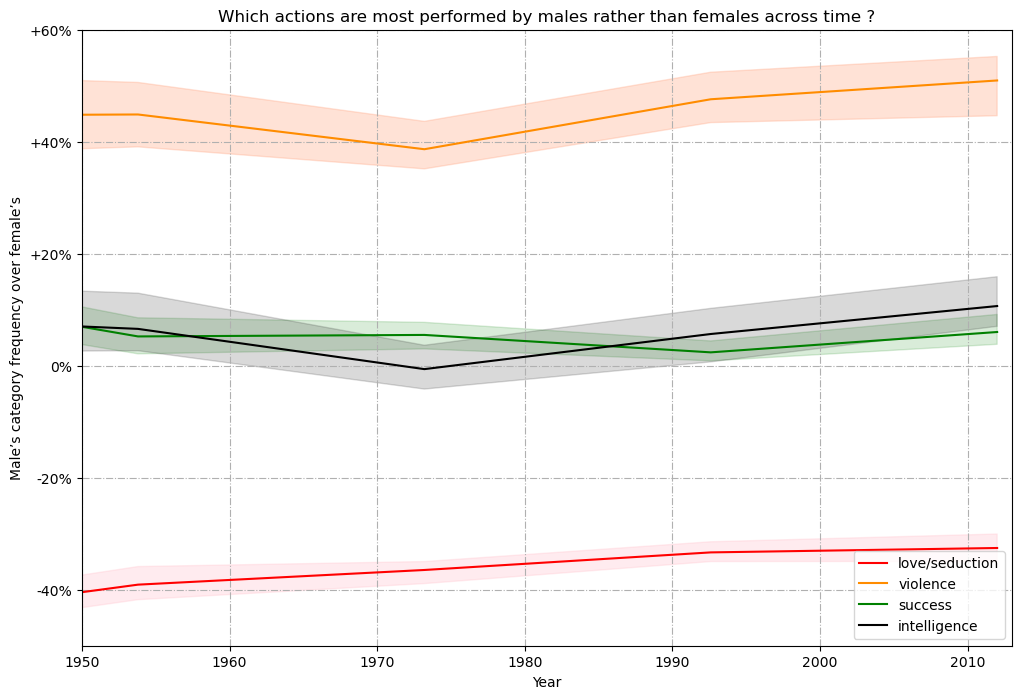

In [110]:
# now we plot our results
f, ax = plt.subplots(figsize = (12,8))
ax.grid(True, linestyle = '-.')
ax.set_ylabel('Male’s category frequency over female’s')
ax.set_xlabel('Year')
ax.set_ylim([-0.5, 0.6])
ax.set_xlim([1950, 2013])

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))

ax.set_title('Which actions are most performed by males rather than females across time ?')
sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_ls, color = 'red', label = 'love/seduction')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_ls, y2=Upper_ls, color ='pink', alpha = 0.3)

sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_v, color = 'darkorange', label = 'violence')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_v, y2=Upper_v, color ='lightsalmon', alpha = 0.3)

sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_s, color = 'green', label = 'success')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_s, y2=Upper_s, color ='green', alpha = 0.15)

sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_i, color = 'black', label = 'intelligence')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_i, y2=Upper_i, color ='black', alpha = 0.15)

#plt.savefig('img.png',dpi=900, format = 'png', bbox_inches = 'tight')

## 5. Gender stereotypes comparison trough movie genres <a class="anchor" id="section5"></a>

In [8]:
# some process on dataframes to get genres of all movies
char_description_total = char_description_total.explode('Movie genres')
genres = ['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller']
df_genres = [char_description_total[char_description_total['Movie genres']==genre] for genre in genres]

In [55]:
# store boostrapped results
Lower_ls, Upper_ls, Mean_ls = [], [], []
Lower_v, Upper_v, Mean_v = [], [], []
Lower_s, Upper_s, Mean_s = [], [], []
Lower_i, Upper_i, Mean_i = [], [], []

for i in range(len(genres)):
    print('advancement : {} / {}'.format(i+1, len(genres)))
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = love_seduction, gender = 'M')
    Lower_ls.append((lower-1))
    Upper_ls.append((upper-1))
    Mean_ls.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = violence, gender = 'M')
    Lower_v.append((lower-1))
    Upper_v.append((upper-1))
    Mean_v.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = success, gender = 'M')
    Lower_s.append((lower-1))
    Upper_s.append((upper-1))
    Mean_s.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = intelligence, gender = 'M')
    Lower_i.append((lower-1))
    Upper_i.append((upper-1))
    Mean_i.append((mean-1))

advancement : 0 / 5
advancement : 1 / 5
advancement : 2 / 5
advancement : 3 / 5
advancement : 4 / 5


In [60]:
# store results into a dataframe
DATA_df = pd.DataFrame.from_dict({'ratio-1': Mean_ls + Mean_v + Mean_s + Mean_i,
                                  'lower': Lower_ls + Lower_v + Lower_s + Lower_i,
                                  'upper': Upper_ls + Upper_v + Upper_s + Upper_i, 
                                  'genre': genres*4, 
                                  'category': ['love/seduction']*5+['violence']*5+['success']*5+['intelligence']*5})
#DATA_df = pd.read_csv('genre_analysis.csv')

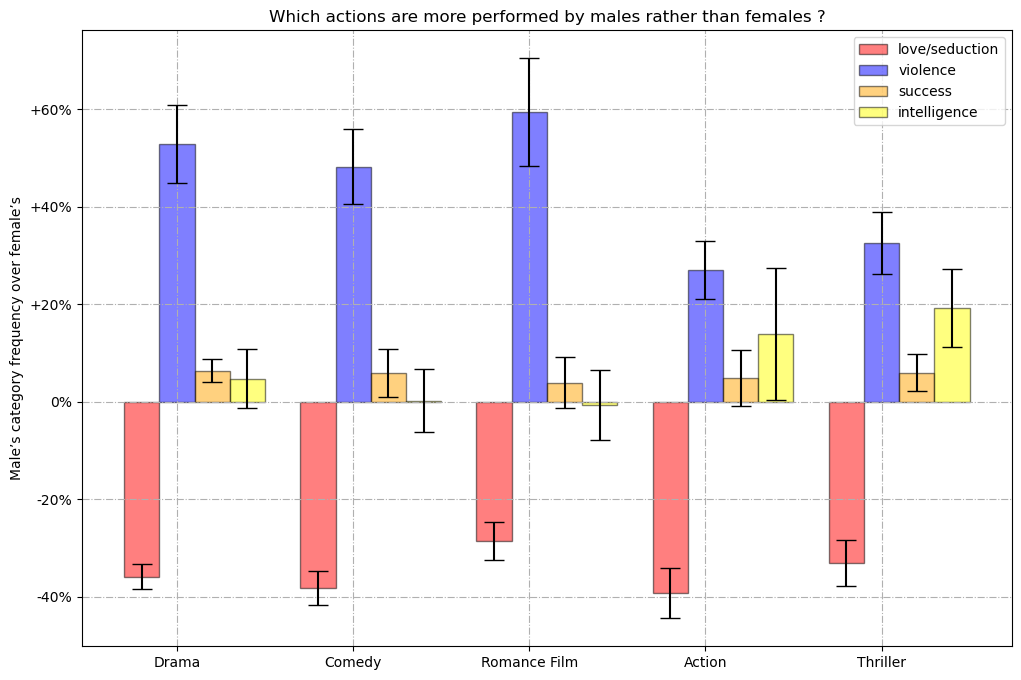

In [107]:
# plot the results
f, ax = plt.subplots(figsize=(12,8))
ax.set_title('Which actions are more performed by males rather than females ?')
ax.grid(True, linestyle = '-.')
barWidth = 0.2
colors = ['red', 'blue', 'orange', 'yellow']

for i, cat in enumerate(DATA_df['category'].drop_duplicates().to_list()):
    bars = DATA_df[DATA_df['category']==cat]['ratio-1'].to_list()
    yer = (DATA_df[DATA_df['category']==cat]['upper']-DATA_df[DATA_df['category']==cat]['lower']).to_list()
    r = [x+barWidth*i for x in np.arange(len(bars))]
    ax.bar(r, bars, width = barWidth, color = colors[i], edgecolor = 'black', yerr=yer, capsize=7, label=cat, alpha = 0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))
ax.set_xticks([r + barWidth for r in range(len(bars))], DATA_df['genre'].drop_duplicates().to_list())
ax.set_ylabel('Male’s category frequency over female’s')
plt.legend()
#plt.savefig('img.png',dpi=500, format = 'png', bbox_inches = 'tight')
plt.show()


## 6. Gender stereotypes comparison trough world region <a class="anchor" id="section6"></a>

In [85]:
# some process on the dataframe to get the world regions
world_regions = ['USA', 'West Europe', 'India']
char_description_total = char_description_total.explode('Movie countries')
char_description_total['Movie countries'] = char_description_total['Movie countries'].replace({'United States of America': 'USA'})

west_europe = ['France','Italy','Germany','Spain','Luxembourg','Netherlands','United Kingdom'] 

for country in west_europe:
    char_description_total['Movie countries'] = char_description_total['Movie countries'].replace({country: 'West Europe'})

char_description_total = char_description_total[char_description_total['Movie countries'].isin(['USA', 'West Europe', 'India'])]
df_region = [char_description_total[char_description_total['Movie countries']==wr] for wr in world_regions]

In [89]:
# store boostrapped results on lists
Lower_ls, Upper_ls, Mean_ls = [], [], []
Lower_v, Upper_v, Mean_v = [], [], []
Lower_s, Upper_s, Mean_s = [], [], []
Lower_i, Upper_i, Mean_i = [], [], []

for i in range(len(world_regions)):
    print('advancement : {} / {}'.format(i+1, len(world_regions)))
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_region[i], action_list = love_seduction, gender = 'M')
    Lower_ls.append((lower-1))
    Upper_ls.append((upper-1))
    Mean_ls.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_region[i], action_list = violence, gender = 'M')
    Lower_v.append((lower-1))
    Upper_v.append((upper-1))
    Mean_v.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_region[i], action_list = success, gender = 'M')
    Lower_s.append((lower-1))
    Upper_s.append((upper-1))
    Mean_s.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_region[i], action_list = intelligence, gender = 'M')
    Lower_i.append((lower-1))
    Upper_i.append((upper-1))
    Mean_i.append((mean-1))

advancement : 1 / 3
advancement : 2 / 3
advancement : 3 / 3


In [102]:
# store results into a dataframe
DATA_df = pd.DataFrame.from_dict({'ratio-1': Mean_ls + Mean_v + Mean_s + Mean_i,
                                  'lower': Lower_ls + Lower_v + Lower_s + Lower_i,
                                  'upper': Upper_ls + Upper_v + Upper_s + Upper_i, 
                                  'world_region': world_regions*4, 
                                  'category': ['love/seduction']*3+['violence']*3+['success']*3+['intelligence']*3})
#DATA_df.to_csv('world_regions.csv', index = False)

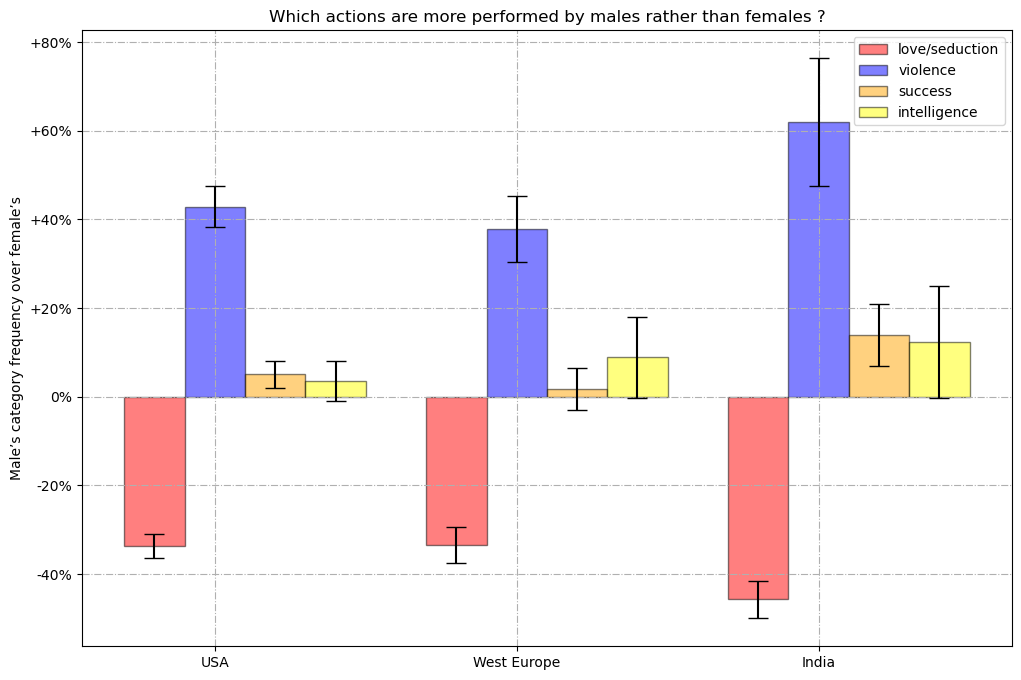

In [100]:
# plot results
f, ax = plt.subplots(figsize=(12,8))
ax.set_title('Which actions are more performed by males rather than females ?')
ax.grid(True, linestyle = '-.')
barWidth = 0.2
colors = ['red', 'blue', 'orange', 'yellow']

for i, cat in enumerate(DATA_df['category'].drop_duplicates().to_list()):
    bars = DATA_df[DATA_df['category']==cat]['ratio-1'].to_list()
    yer = (DATA_df[DATA_df['category']==cat]['upper']-DATA_df[DATA_df['category']==cat]['lower']).to_list()
    r = [x+barWidth*i for x in np.arange(len(bars))]
    ax.bar(r, bars, width = barWidth, color = colors[i], edgecolor = 'black', yerr=yer, capsize=7, label=cat, alpha = 0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))
ax.set_xticks([r + barWidth for r in range(len(bars))], DATA_df['world_region'].drop_duplicates().to_list())
ax.set_ylabel('Male’s category frequency over female’s')
plt.legend()
#plt.savefig('img.png',dpi=500, format = 'png', bbox_inches = 'tight')
plt.show()


## 7. Gender stereotypes comparison through writer's gender <a class="anchor" id="section7"></a>

### Obtaining the number of male and females writers and directors for each movie in the dataset

In [7]:
#Importing the metadata from CMU Movie Summary Corpus
df_movie_meta = pd.read_table("./data/MovieSummaries/movie.metadata.tsv", header=None)
df_movie_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", 
                     "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres"]


In [8]:
# To map freebase ids to imdb ids
fb_to_imdb = pd.read_csv('freebase_to_imdb.csv')
# drop columns that are not needed
fb_to_imdb.drop(columns = ['sitelink', 'item'], inplace = True)
fb_to_imdb.head(3)

,freebaseID,IMDb_ID
0,/m/05cj_j,tt0074512
1,/m/0d1t3h,tt0079630
2,/m/0gt35,tt0031971


In [14]:
data_folder_IMDB = './IMDb data/'
# Importing the data on the cast
f = gzip.open(data_folder_IMDB + '/title.crew.tsv.gz', 'rb')
df_title_crew=  pd.read_csv(f, sep='\t')
df_title_crew.head(3)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N


In [11]:
f = gzip.open(data_folder_IMDB + '/title.basics.tsv.gz', 'rb')
df_title_basics =  pd.read_csv(f, sep='\t')
df_title_basics = df_title_basics.drop(columns = ['isAdult', 'endYear', 'startYear', 'runtimeMinutes', 'titleType'])

# Getting imdb ids matching freebase ids
df_movie_meta = df_movie_meta.drop(columns = ['Movie runtime', 'Movie countries', 'Movie languages', 'Movie box office revenue', 'Movie release date'])
data = df_movie_meta.merge(fb_to_imdb, how = 'inner', left_on = 'Freebase movie ID', right_on = 'freebaseID' )

# Merging cmu and imdb movies
merged_cmu_imdb = data.merge(df_title_basics, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')
merged_cmu_imdb = merged_cmu_imdb.drop(columns = ['tconst', 'originalTitle', 'genres', 'freebaseID', 'primaryTitle'])
merged_cmu_imdb.head(3)

c:\Users\33642\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie genres,IMDb_ID
0,975900,/m/03vyhn,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333
1,28463795,/m/0crgdbh,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",tt0094806
2,9363483,/m/0285_cd,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320


In [17]:
# Obtaining the crew for each movie
merged_cmu_imdb = merged_cmu_imdb.merge(df_title_crew, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')
merged_cmu_imdb = merged_cmu_imdb.drop(columns = ['tconst', 'Movie genres'])
merged_cmu_imdb.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,nm0000118,"nm0837917,nm0000118"
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,nm0803751,"nm0803751,nm0820866"
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"


We now have the writers and directors information for the movies. We can have more than one writer and director per movie.

In [20]:
# Selecting subsets of the dataframe 
df_directors = merged_cmu_imdb[['Freebase movie ID', 'directors']]
df_writers = merged_cmu_imdb[['Freebase movie ID', 'writers']]
# Splitting the directors into a list
df_directors['directors'] = df_directors['directors'].apply(lambda x : x.split(','))
# Splitting the writers into a list
df_writers['writers'] = df_writers['writers'].apply(lambda x : x.split(','))

In [22]:
gender_imdb = pd.read_csv('imdb_genders.csv')
gender_imdb['gender'] = gender_imdb['gender'].apply(lambda x : str(x).rsplit('/', 1)[-1])
gender_imdb = gender_imdb.drop(columns = ['id'])
# Replacing male and female genders and keeping only them. We don't consider other genres because they are too few
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581097', 'male')
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581072', 'female')
gender_imdb = gender_imdb[gender_imdb['gender'].str.contains('male|female')]

In [23]:
# Putting only one director and writer per line
df_directors = df_directors.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()
df_writers = df_writers.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()
# keeping only unique directors and writers
df_writers_unique = df_writers.drop_duplicates(subset = 'writers')
df_directors_unique = df_directors.drop_duplicates(subset = 'directors')
# Getting their imdb ids
df_wri = df_writers_unique.merge(gender_imdb, how = 'inner', left_on='writers', right_on = 'IMDb_ID')
df_dir = df_directors_unique.merge(gender_imdb, how = 'inner', left_on='directors', right_on = 'IMDb_ID')
df_wri.head(3)

,Freebase movie ID,writers,gender,IMDb_ID
0,/m/03vyhn,nm0000118,male,nm0000118
1,/m/0crgdbh,nm0803751,male,nm0803751
2,/m/0crgdbh,nm0820866,male,nm0820866


In [28]:
gender_writers = df_wri[['writers', 'gender']]
gender_directors = df_dir[['directors', 'gender']]
gender_writers.head(3)

,writers,gender
0,nm0000118,male
1,nm0803751,male
2,nm0820866,male


In [29]:
gender_directors = gender_directors.drop_duplicates(subset = ['directors'])
print(gender_directors.directors.is_unique)
gender_directors = gender_directors.set_index(['directors'])
gender_writers = gender_writers.drop_duplicates(subset = ['writers'])
gender_writers.writers.is_unique
gender_writers = gender_writers.set_index(['writers'])

True


male      24027
female     3841
Name: gender, dtype: int64


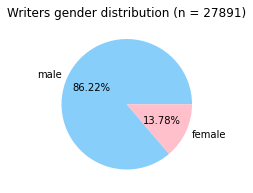

<Figure size 432x288 with 0 Axes>

In [30]:
print(df_wri['gender'].value_counts())

mylabels = ["male", "female"]
fig = plt.figure(figsize=(6,3)) 
colors = ['lightskyblue','pink']
plt.pie(df_wri['gender'].value_counts(), labels = mylabels, autopct='%1.2f%%', colors = colors)
plt.title("Writers gender distribution (n = 27891)")
plt.figure(facecolor='yellow')
plt.show()
fig.savefig('writers_gender.png', format='png', dpi=900)

male      15568
female     1657
Name: gender, dtype: int64


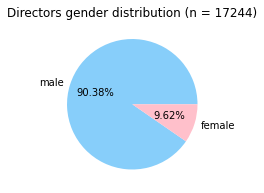

<Figure size 432x288 with 0 Axes>

In [31]:
print(df_dir['gender'].value_counts())

mylabels = ["male", "female"]
fig = plt.figure(figsize=(6,3)) 
colors = ['lightskyblue','pink']
plt.pie(df_dir['gender'].value_counts(), labels = mylabels, autopct='%1.2f%%', colors = colors)
plt.title("Directors gender distribution (n = 17244)")
plt.figure(facecolor='yellow')
plt.show()
fig.savefig('myimage.png', format='png', dpi=900)

In [32]:
merged_cmu_imdb['writers'] = merged_cmu_imdb['writers'].apply(lambda x : x.split(','))
merged_cmu_imdb['directors'] = merged_cmu_imdb['directors'].apply(lambda x : x.split(','))
merged_cmu_imdb.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,[nm0000118],"[nm0837917, nm0000118]"
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,[nm0803751],"[nm0803751, nm0820866]"
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,[nm0131910],"[nm0465026, nm0131910, nm0458461, nm1738738]"


In [33]:
def get_gender_counts(lst, dataframe):
    """
    takes a list of ids as input and a table of gender linked to ids
    returns counts of men and women in the list of ids
    """
    
    male_count = 0
    female_count = 0
    unknown = 0
    if len(lst) == 0:
        return 0,0,0
    for id in lst:
        gender = dataframe[dataframe.index == id]['gender']
        if len(gender) == 1 :
            gender = gender.item()
            if gender == 'male':
                male_count += 1
            elif gender == 'female':
                female_count += 1
        else : 
            unknown += 1
    return [male_count, female_count, unknown]

In [34]:
df = merged_cmu_imdb.copy()
df['counts_dir'] = df['directors'].apply(lambda x: get_gender_counts(x, gender_directors))
df['counts_wri'] = df['writers'].apply(lambda x: get_gender_counts(x, gender_writers))
df.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers,counts_dir,counts_wri
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,[nm0000118],"[nm0837917, nm0000118]","[1, 0, 0]","[1, 0, 1]"
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,[nm0803751],"[nm0803751, nm0820866]","[1, 0, 0]","[2, 0, 0]"
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,[nm0131910],"[nm0465026, nm0131910, nm0458461, nm1738738]","[1, 0, 0]","[2, 1, 1]"


In [35]:
# Separating the counts into columns
df['male_writers'] = df['counts_wri'].apply(lambda x: x[0])
df['female_writers'] = df['counts_wri'].apply(lambda x: x[1])
df['unknown_writers'] = df['counts_wri'].apply(lambda x: x[2])

df['male_dir'] = df['counts_dir'].apply(lambda x: x[0])
df['female_dir'] = df['counts_dir'].apply(lambda x: x[1])
df['unknown_dir'] = df['counts_dir'].apply(lambda x: x[2])

df = df.drop(columns = ['counts_wri', 'counts_dir'])

In [36]:
df_with_dir_gender = df[df['male_dir'] + df['female_dir'] != 0]
print('The number of movies for which we have at least one director is: ' + str(len(df_with_dir_gender)))

The number of movies for which we have at least one director is: 55314


In [43]:
print('The fraction of movies with more male directors than female directors is: ' + str(round(len(df_with_dir_gender[df_with_dir_gender['male_dir']>df_with_dir_gender['female_dir']])/len(df_with_dir_gender),3)))
print('The fraction of movies with as much male directors as female directors is: ' + str(round(len(df_with_dir_gender[df_with_dir_gender['male_dir'] == df_with_dir_gender['female_dir']])/len(df_with_dir_gender),3)))
print('The fraction of movies with more female directors than male directors is: ' + str(round(len(df_with_dir_gender[df_with_dir_gender['male_dir'] < df_with_dir_gender['female_dir']])/len(df_with_dir_gender),3)))

The fraction of movies with more male directors than female directors is: 0.949
The fraction of movies with as much male directors as female directors is: 0.006
The fraction of movies with more female directors than male directors is: 0.045


In [45]:
df_with_wri_gender = df[df['male_writers'] + df['female_writers'] != 0]
print('The number of movies for which we have at least one director is: ' + str(len(df_with_wri_gender)))

The number of movies for which we have at least one director is: 50123


In [46]:
print('The fraction of movies with more male writers than female directors is: ' + str(round(len(df_with_wri_gender[df_with_wri_gender['male_writers']>df_with_wri_gender['female_writers']])/len(df_with_wri_gender),3)))
print('The fraction of movies with as much male writers as female writers is: ' + str(round(len(df_with_wri_gender[df_with_wri_gender['male_writers'] == df_with_wri_gender['female_writers']])/len(df_with_wri_gender),3)))
print('The fraction of movies with more female directors than male directors is: '+ str(round(len(df_with_wri_gender[df_with_wri_gender['male_writers'] < df_with_wri_gender['female_writers']])/len(df_with_wri_gender),3)))


The fraction of movies with more male writers than female directors is: 0.888
The fraction of movies with as much male writers as female writers is: 0.055
The fraction of movies with more female directors than male directors is: 0.057


In [47]:
df.to_pickle('dir_writers_genders.p')

In [4]:
# This is our final dataframe
pd.read_pickle('dir_writers_genders.p')


,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers,male_writers,female_writers,unknown_writers,male_dir,female_dir,unknown_dir
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,[nm0000118],"[nm0837917, nm0000118]",1,0,1,1,0,0
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,[nm0803751],"[nm0803751, nm0820866]",2,0,0,1,0,0
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,[nm0131910],"[nm0465026, nm0131910, nm0458461, nm1738738]",2,1,1,1,0,0
3,261236,/m/01mrr1,A Woman in Flames,tt0083949,[nm0885554],"[nm0885554, nm0959016]",1,0,1,1,0,0
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,tt0029852,[nm0454771],"[nm0778636, nm0873707, nm0792553, nm0000927, n...",4,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
61939,23851782,/m/06_vb43,The Ghost Train,tt0033660,[nm0285962],"[nm0725965, nm0651357, nm0346436, nm0249218]",4,0,0,1,0,0
61940,32468537,/m/0crwd9y,Shadow Boxing 2,tt0459759,[nm2415918],"[nm1284414, nm12760099]",1,0,1,1,0,0
61941,34980460,/m/0g4pl34,Knuckle,tt1606259,[nm3817974],[\N],0,0,1,0,0,1
61942,9971909,/m/02pygw1,Another Nice Mess,tt0362411,[nm0251872],[nm0251872],1,0,0,1,0,0


Now we can merge thanks to the wikipedia movie ID and do our analysis !

In [132]:
# open data on writers/ directors from imdb database
dir_writ_df = pd.read_pickle('./MovieSummaries/dir_writers_genders.p')

# merge with our actiosn dataframe
merge_dir_wr_df = char_description_total.merge(dir_writ_df, on = 'Wikipedia movie ID')

In [141]:
# preprocess to get movies with at least one females writer, 
# and movies with zero females writer
df_writers = []
df_writers.append(merge_dir_wr_df.query('female_writers>0'))
df_writers.append(merge_dir_wr_df.query('female_writers==0'))

In [142]:
# compute and store bootstrapped results
Lower_ls, Upper_ls, Mean_ls = [], [], []
Lower_v, Upper_v, Mean_v = [], [], []
Lower_s, Upper_s, Mean_s = [], [], []
Lower_i, Upper_i, Mean_i = [], [], []

for i in range(2):
    print('advancement : {} / {}'.format(i+1, 2))
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_writers[i], action_list = love_seduction, gender = 'M')
    Lower_ls.append((lower-1))
    Upper_ls.append((upper-1))
    Mean_ls.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_writers[i], action_list = violence, gender = 'M')
    Lower_v.append((lower-1))
    Upper_v.append((upper-1))
    Mean_v.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_writers[i], action_list = success, gender = 'M')
    Lower_s.append((lower-1))
    Upper_s.append((upper-1))
    Mean_s.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_writers[i], action_list = intelligence, gender = 'M')
    Lower_i.append((lower-1))
    Upper_i.append((upper-1))
    Mean_i.append((mean-1))

advancement : 1 / 2
advancement : 2 / 2


In [143]:
# store results into a dataframe 
DATA_df = pd.DataFrame.from_dict({'ratio-1': Mean_ls + Mean_v + Mean_s + Mean_i,
                                  'lower': Lower_ls + Lower_v + Lower_s + Lower_i,
                                  'upper': Upper_ls + Upper_v + Upper_s + Upper_i, 
                                  'writer': ['at least one woman', 'no woman']*4, 
                                  'category': ['love/seduction']*2+['violence']*2+['success']*2+['intelligence']*2})
#DATA_df = pd.read_csv('writer_impact_gender_actions.csv')

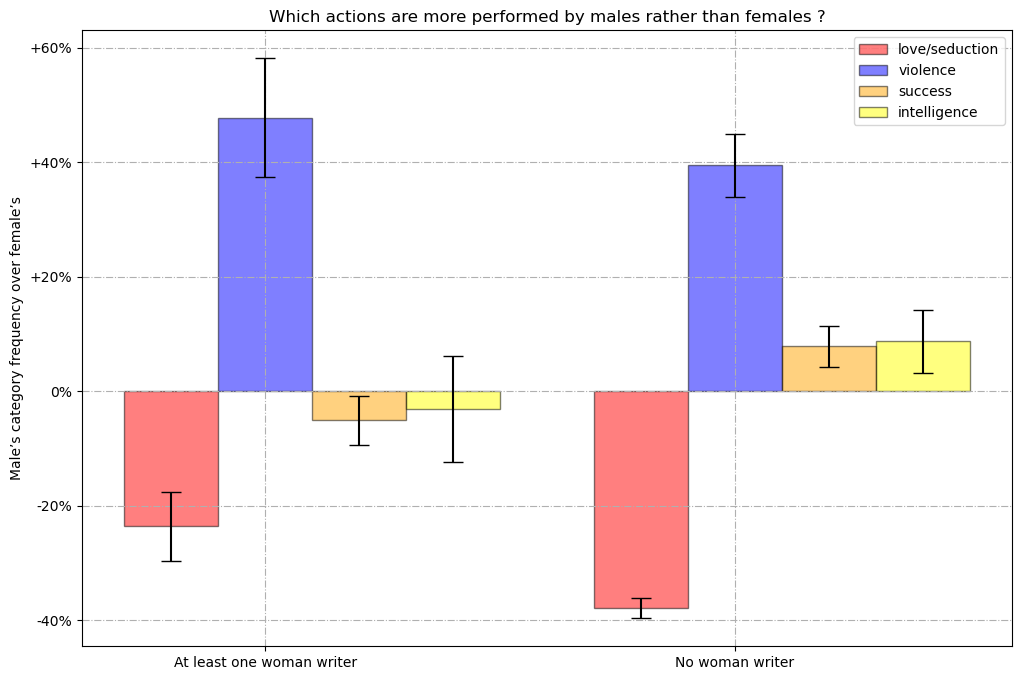

In [163]:
# plot results 
f, ax = plt.subplots(figsize=(12,8))
ax.set_title('Which actions are more performed by males rather than females ?')
ax.grid(True, linestyle = '-.')
barWidth = 0.2
colors = ['red', 'blue', 'orange', 'yellow']

for i, cat in enumerate(DATA_df['category'].drop_duplicates().to_list()):
    bars = DATA_df[DATA_df['category']==cat]['ratio-1'].to_list()
    yer = (DATA_df[DATA_df['category']==cat]['upper']-DATA_df[DATA_df['category']==cat]['lower']).to_list()
    r = [x+barWidth*i for x in np.arange(len(bars))]
    ax.bar(r, bars, width = barWidth, color = colors[i], edgecolor = 'black', yerr=yer, capsize=7, label=cat, alpha = 0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))
ax.set_xticks([r + barWidth for r in range(len(bars))], ['At least one woman writer', 'No woman writer'])
ax.set_ylabel('Male’s category frequency over female’s')
plt.legend()
#plt.savefig('img.png',dpi=900, format = 'png', bbox_inches = 'tight')
plt.show()

## 8. Gender stereotypes comparison through producer's gender <a class="anchor" id="section8"></a>

In [149]:
# preprocess to get movies with at least one females director, 
# and movies with zero females director.
df_directors = []
df_directors.append(merge_dir_wr_df.query('female_dir>0'))
df_directors.append(merge_dir_wr_df.query('female_dir==0'))

In [150]:
# compute and store boostrapped results
Lower_ls, Upper_ls, Mean_ls = [], [], []
Lower_v, Upper_v, Mean_v = [], [], []
Lower_s, Upper_s, Mean_s = [], [], []
Lower_i, Upper_i, Mean_i = [], [], []

for i in range(2):
    print('advancement : {} / {}'.format(i+1, 2), end =' ')
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_directors[i], action_list = love_seduction, gender = 'M')
    Lower_ls.append((lower-1))
    Upper_ls.append((upper-1))
    Mean_ls.append((mean-1))
    print('  •', end =' ')
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_directors[i], action_list = violence, gender = 'M')
    Lower_v.append((lower-1))
    Upper_v.append((upper-1))
    Mean_v.append((mean-1))
    print('•', end =' ')
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_directors[i], action_list = success, gender = 'M')
    Lower_s.append((lower-1))
    Upper_s.append((upper-1))
    Mean_s.append((mean-1))
    print('•', end =' ')
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_directors[i], action_list = intelligence, gender = 'M')
    Lower_i.append((lower-1))
    Upper_i.append((upper-1))
    Mean_i.append((mean-1))
    print('•')

advancement : 1 / 2   • • • •
advancement : 2 / 2   • • • •


In [155]:
# store results into a dataframe
DATA_df = pd.DataFrame.from_dict({'ratio-1': Mean_ls + Mean_v + Mean_s + Mean_i,
                                  'lower': Lower_ls + Lower_v + Lower_s + Lower_i,
                                  'upper': Upper_ls + Upper_v + Upper_s + Upper_i, 
                                  'director': ['At least one woman directing', 'No woman directing']*4, 
                                  'category': ['love/seduction']*2+['violence']*2+['success']*2+['intelligence']*2})
#DATA_df.to_csv('dir_impact_gender_actions.csv', index=False)

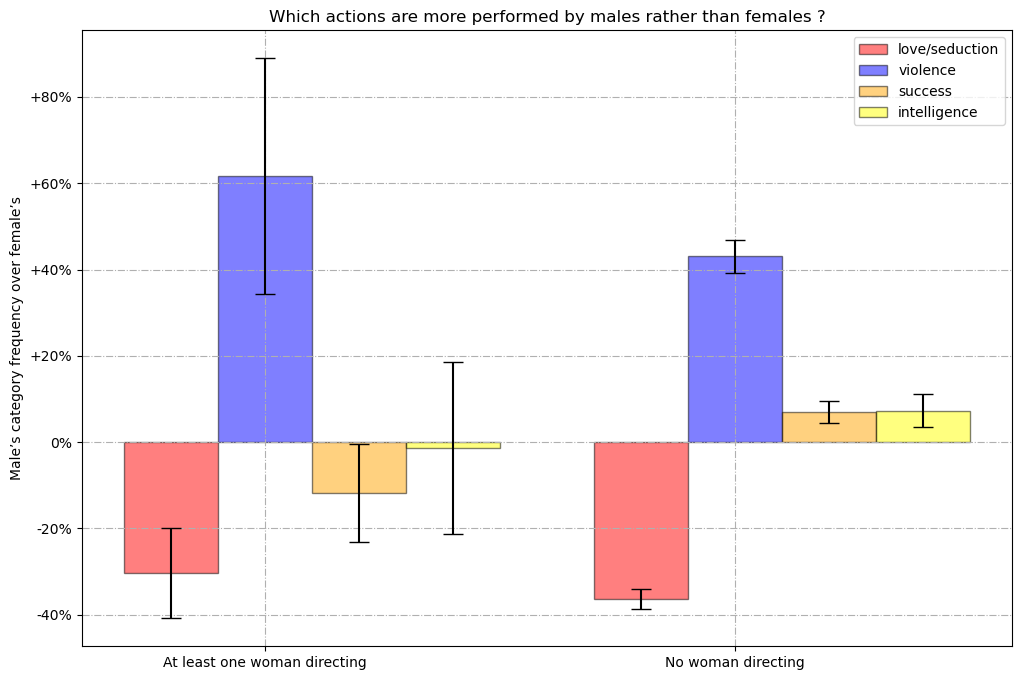

In [158]:
# plot results
f, ax = plt.subplots(figsize=(12,8))
ax.set_title('Which actions are more performed by males rather than females ?')
ax.grid(True, linestyle = '-.')
barWidth = 0.2
colors = ['red', 'blue', 'orange', 'yellow']

for i, cat in enumerate(DATA_df['category'].drop_duplicates().to_list()):
    bars = DATA_df[DATA_df['category']==cat]['ratio-1'].to_list()
    yer = (DATA_df[DATA_df['category']==cat]['upper']-DATA_df[DATA_df['category']==cat]['lower']).to_list()
    r = [x+barWidth*i for x in np.arange(len(bars))]
    ax.bar(r, bars, width = barWidth, color = colors[i], edgecolor = 'black', yerr=yer, capsize=7, label=cat, alpha = 0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))
ax.set_xticks([r + barWidth for r in range(len(bars))], DATA_df['director'].drop_duplicates().to_list())
ax.set_ylabel('Male’s category frequency over female’s')
plt.legend()
#plt.savefig('img.png',dpi=900, format = 'png', bbox_inches = 'tight')
plt.show()